In [1]:
import warnings; warnings.simplefilter('ignore')
import os
import sys
import time
import math
import shutil
import pickle
import random
import anndata
import operator
import matplotlib
import pylab as pl
import numpy as np
import pandas as pd
from umap import UMAP
import seaborn as sns
from scipy import sparse
from matplotlib import cm
from fish_helpers import *
from IPython import display
import tqdm#.notebook as tqdm
from scipy.stats import mode
from functools import partial
from segmentation_3D import *
import matplotlib.pyplot as plt
from multiprocessing import Pool
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib._color_data as mcd
import scipy.cluster.hierarchy as shc
from scipy.interpolate import interp1d
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics.pairwise import euclidean_distances
base = '/bigstore/binfo/mouse/Hippocampus/'

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
"""
Load seperability filtered counts
"""
filtered_counts_sparse = sparse.load_npz(os.path.join(base,'Allen/seperability_filtered_counts.npz'))
filtered_counts = filtered_counts_sparse.A
cells = list(pd.read_csv(os.path.join(base,'Allen/seperability_filtered_cells.csv'),index_col=0)['0'])
filtered_genes = list(pd.read_csv(os.path.join(base,'Allen/seperability_filtered_genes.csv'),index_col=0)['0'])

In [3]:
"""
Decoding dendogram
Converting to linkage
"""
import json
with open('/bigstore/binfo/mouse/Hippocampus/dend.json') as json_file:
    data = json.load(json_file)
def inspect_node(node):
    if 'leaf_attributes' in node.keys():
        attributes = node['leaf_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        a = 'None'
        b = 'None'
        children = False
    else:
        attributes = node['node_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        children = node['children']
        a_node = node['children'][0]
        if 'leaf_attributes' in a_node.keys():
            a = a_node['leaf_attributes'][0]['node_id']
        else:
            a = a_node['node_attributes'][0]['node_id']
        b_node = node['children'][1]
        if 'leaf_attributes' in b_node.keys():
            b = b_node['leaf_attributes'][0]['node_id']
        else:
            b = b_node['node_attributes'][0]['node_id']
    return c,h,a,b,children

C = []
H = []
A = []
B = []
node_dict = {}

node = data
c,h,a,b,children = inspect_node(node)
C.append(c)
H.append(h)
A.append(a)
B.append(b)
while len(children)>0:
    new_children = []
    for node in children:
        c,h,a,b,node_children = inspect_node(node)
        C.append(c)
        H.append(h)
        A.append(a)
        B.append(b)
        if isinstance(node_children,list):
            new_children.extend(node_children)
    children = new_children
linkage = pd.DataFrame()
linkage['C'] = C
linkage['H'] = H
linkage['A'] = A
linkage['B'] = B
print(len(C))
"""
Convert linkage to dendrogram format
"""
sorted_linkage = linkage.sort_values('H',ascending=True)
sorted_linkage['n'] = range(len(sorted_linkage))
nA = []
for A in sorted_linkage['A']:
    if A!='None':
        nA.append(np.array(sorted_linkage[sorted_linkage['C']==A]['n'])[0])
    else:
        nA.append('None')
nB = []
for B in sorted_linkage['B']:
    if B!='None':
        nB.append(np.array(sorted_linkage[sorted_linkage['C']==B]['n'])[0])
    else:
        nB.append('None')
sorted_linkage['nA'] = nA
sorted_linkage['nB'] = nB
sorted_linkage['nC'] = list(sorted_linkage['n'])
sorted_linkage = sorted_linkage[sorted_linkage['H']>0]
sorted_linkage = sorted_linkage.sort_values('H',ascending=True)
"""
Convert to shc format
"""
linkage_shc = np.zeros((len(sorted_linkage),4))
linkage_shc[:,0] = sorted_linkage['nA']
linkage_shc[:,1] = sorted_linkage['nB']
linkage_shc[:,2] = sorted_linkage['H']
linkage_shc[:,3] = 1

579


In [4]:
"""
Convert to cell type by node matrix
"""
def find_next_node(i,df):
    temp = df[(df['A']==i)|(df['B']==i)]
    if len(temp)==1:
        return temp['C'].iloc[0]
    else:
        return False
def linkage2binary(linkage,cells):
    nnodes = len(linkage)
    ncells = len(cells)
    binary_node_matrix = np.zeros((ncells,nnodes))
    first_node = linkage['C'].iloc[0]
    for i,cell in tqdm.tqdm(enumerate(cells),total=ncells):
        node_loc = list(linkage[linkage['C']==cell].index)[0]
        binary_node_matrix[i,node_loc]=1
        new_node = find_next_node(cell,linkage)
        while isinstance(new_node,str):
            node_loc = list(linkage[linkage['C']==new_node].index)[0]
            binary_node_matrix[i,node_loc]=1
            new_node = find_next_node(new_node,linkage)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=cells,columns=list(linkage['C']))
    return binary_node_df
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
binary_node_df = linkage2binary(linkage,good_types).T

100%|██████████| 290/290 [00:13<00:00, 20.86it/s]


In [5]:
node_matrix = np.zeros((len(cells),len(binary_node_df.index)))
for cell_type in tqdm.tqdm(good_types):
    cell_type_cells = list(metadata[metadata['cell_type_alias_label']==cell_type].index)
    cell_type_cells = list(set(cell_type_cells).intersection(cells))
    cell_type_node = np.array(binary_node_df[cell_type])
    node_matrix[np.where(np.isin(cells,cell_type_cells)),:] = cell_type_node
node_df = pd.DataFrame(node_matrix,index=cells,columns=binary_node_df.index)

100%|██████████| 290/290 [00:23<00:00, 12.17it/s]


In [6]:
"""
Metric for dendrogram accuracy
sum of (weights+1 * accuracy)/ncells 
weights = node by weight df linkage['H']
ncells = node by ncells df from node_df
could be same df
"""
temp = linkage
temp.index = temp['C']
node_metrics = pd.DataFrame(index=node_df.columns)
node_metrics['weights'] = 1+pd.DataFrame(temp['H'])
node_metrics['ncells'] = pd.DataFrame(node_df.sum())
node_metrics

,weights,ncells
n1,1.8416,74967.0
n2,1.6271,74101.0
n281,1.7175,866.0
n3,1.3650,72893.0
n274,1.5365,1208.0
n283,1.5418,681.0
n282,1.2631,185.0
n4,1.2512,72854.0
CR,1.0000,39.0
n277,1.4810,1057.0


In [7]:
"""
Filtered CSI matrix format
"""
matrix_df = pd.DataFrame(filtered_counts,index=filtered_genes,columns=cells)
avg = np.median(filtered_counts,axis=1)
std = np.std(filtered_counts,axis=1)
zscore = pd.DataFrame(filtered_counts-avg[:,None]/std[:,None],index=filtered_genes,columns=cells)
info_df = metadata.loc[cells]
info_df['cell_type'] = info_df['cell_type_alias_label']
info_df

,cluster_color,cluster_order,cluster_label,class_color,class_order,class_label,subclass_color,subclass_order,subclass_label,full_genotype_color,...,injection_roi_color,injection_roi_order,injection_roi_label,propagation_type_color,propagation_type_order,propagation_type_label,subregion_color,subregion_order,subregion_label,cell_type
sample_name,,,,,,,,,,,,,,,,,,,,,
SM-GE669_S180_E1-50,#3842EC,94,DG_2,#0078C3,2,Glutamatergic,#394FD3,12,DG,#522E99,...,#FF7373,1,NaN,#FF7373,1,NaN,#006B99,12,anterior,DG_2
SQ-80015_S33_E1-50,#0E9797,159,L4/5 IT_4,#0078C3,2,Glutamatergic,#00E5E5,23,L4/5 IT,#CC473D,...,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN,L4/5 IT_4
SM-GE93C_S038_E1-50,#00FF66,271,CR,#0078C3,2,Glutamatergic,#00FF66,38,CR,#00FF99,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,CR
SM-GE8Z8_S370_E1-50,#2191CF,164,L4 IT_4,#0078C3,2,Glutamatergic,#00E297,22,L4 IT,#7D26FF,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,L4 IT_4
SM-GE5TP_S167_E1-50,#A68CFF,253,CA1sp_1,#0078C3,2,Glutamatergic,#841AFF,35,CA1sp,#7D26FF,...,#FF7373,1,NaN,#FF7373,1,NaN,#52FF26,7,posterior,CA1sp_1
SM-GE679_S037_E1-50,#D4303B,83,Pvalb_7,#FF9F2C,1,GABAergic,#D93137,9,Pvalb,#921FCC,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,Pvalb_7
SM-D9D91_S64_E1-50,#ADD5B3,290,Macrophage_2,#665C47,3,Non-neuronal,#94AF97,44,Macrophage,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,Macrophage_2
SM-DAIFW_S61_E1-50,#21D238,129,L2/3 IT Otof_5,#0078C3,2,Glutamatergic,#0BE652,19,L2/3 IT Otof,#7D26FF,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,L2/3 IT Otof_5
SM-GE63V_S055_E1-50,#520CB9,183,Car3_2,#0078C3,2,Glutamatergic,#5100FF,25,Car3,#479900,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,Car3_2


In [8]:
"""
Calculate seperability vector for each gene for all nodes
"""


'\nCalculate seperability vector for each gene for all nodes\n'

In [9]:
"""
Build cell type to cell type weight matrix
"""
n_cell_types = len(good_types)
weight_matrix = np.zeros((n_cell_types,n_cell_types))
for x,cell_type1 in tqdm.tqdm(enumerate(good_types),total=n_cell_types):
    for y,cell_type2 in enumerate(good_types):
        if x<y:
            ancester_nodes = list(binary_node_df[(binary_node_df[cell_type1]==1)&(binary_node_df[cell_type2]==1)].index)
            weight = np.min(linkage[linkage['C'].isin(ancester_nodes)]['H'])
            weight_matrix[x,y] = weight
            weight_matrix[y,x] = weight
weight_matrix_df = pd.DataFrame(weight_matrix,index=good_types,columns=good_types)

100%|██████████| 290/290 [01:51<00:00,  2.60it/s]


In [10]:
"""
Generating Cell Type Lookup Table
"""
cell_type_loc = {}
labels = np.array(metadata['cell_type_alias_label'].loc[list(cells)])
for cell_type in np.unique(labels):
    cell_type_loc[cell_type] = np.where(labels==cell_type)[0]

In [11]:
"""
Calculate median and variance for each gene for each cell type
"""
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(filtered_genes)
cell_type_medians = np.zeros((n_cell_types,ngenes))
cell_type_variance = np.zeros((n_cell_types,ngenes))
for i,cell_type in tqdm.tqdm(enumerate(cell_types),total=n_cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        cel_type_counts = filtered_counts[:,loc]
        cell_type_medians[i,:] = np.median(cel_type_counts,axis=1)
        cell_type_variance[i,:] = np.std(cel_type_counts,axis=1)

100%|██████████| 290/290 [00:05<00:00, 57.02it/s]


In [56]:
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
weighted_seperability_matrix = np.zeros((n_cell_types,n_cell_types,ngenes))
unweighted_seperability_matrix = np.zeros((n_cell_types,n_cell_types,ngenes))
seperability_matrix = np.zeros_like(cell_type_medians)
for i in tqdm.tqdm(range(n_cell_types),total=n_cell_types):
    median = cell_type_medians[i,:]
    variance = cell_type_variance[i,:]
#     delta_medians = np.abs(np.subtract(cell_type_medians,median[None,:]))
    delta_medians = np.subtract(cell_type_medians,median[None,:])
    sigma_variances = np.add(cell_type_variance,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    seperability = np.nan_to_num(seperability)
    unweighted_seperability_matrix[i,:,:] = seperability
    weighted_seperability = np.multiply(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    weighted_seperability_matrix[i,:,:] = weighted_seperability
    seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
total_seperation = np.sum(seperability_matrix,axis=0)

100%|██████████| 290/290 [00:03<00:00, 93.65it/s]


In [98]:
correlation_matrix = np.ones((ngenes,ngenes))
for x in seperability_matrix.shape[1]:
    x1 = seperability_matrix[:,x]
    for y in range(seperability_matrix.shape[1]):
        if x<y:
            c = pearsonr(x1,seperability_matrix[:,y])[0]
            correlation_matrix[x,y] = c
            correlation_matrix[y,x] = c


100%|██████████| 1220/1220 [03:02<00:00,  6.70it/s]


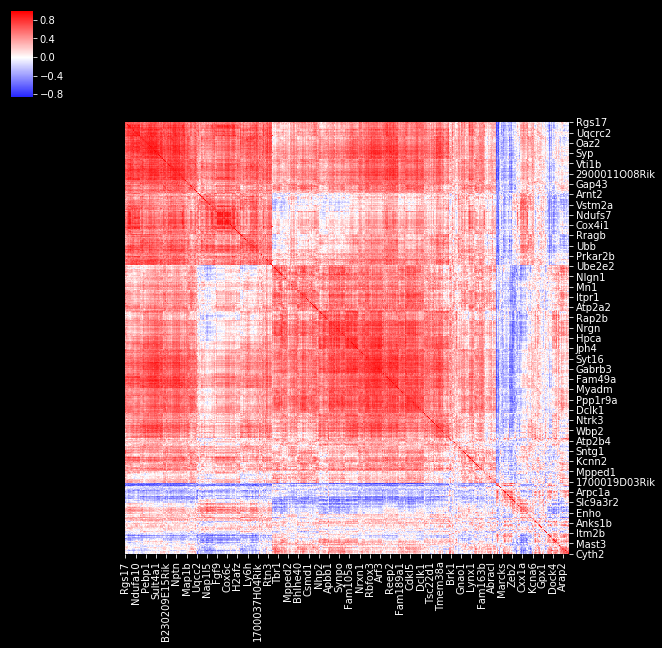

In [100]:
sns.clustermap(pd.DataFrame(correlation_matrix,index=filtered_genes,columns=filtered_genes),cmap='bwr',center=0)
plt.show()

0.05217176308218023
0.23016147805549436


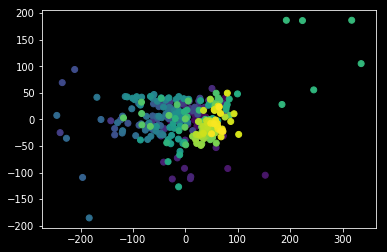

In [101]:
x = seperability_matrix[:,0]
y = seperability_matrix[:,1]
print(spearmanr(x,y)[0])
print(pearsonr(x,y)[0])
plt.scatter(x,y,c=range(len(x)))
plt.show()

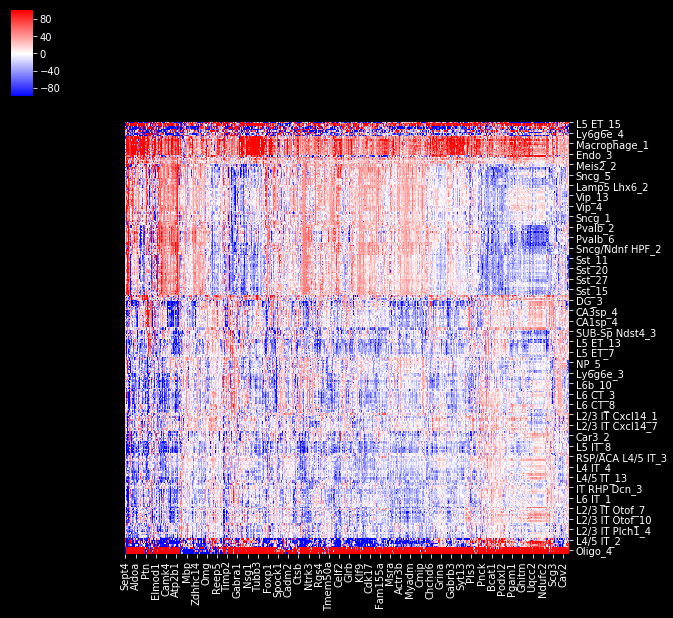

In [57]:
plt.style.use(['dark_background'])
df = pd.DataFrame(seperability_matrix,index=cell_types,columns=filtered_genes)
sns.clustermap(df,cmap='bwr',center=0,vmin=-100,vmax=100)
plt.show()

In [ ]:
plt.style.use(['dark_background'])
df = pd.DataFrame(seperability_matrix,index=cell_types,columns=filtered_genes)
sns.clustermap(df,cmap='bwr',center=0,vmin=-100,vmax=100,metric='correlation')
plt.show()

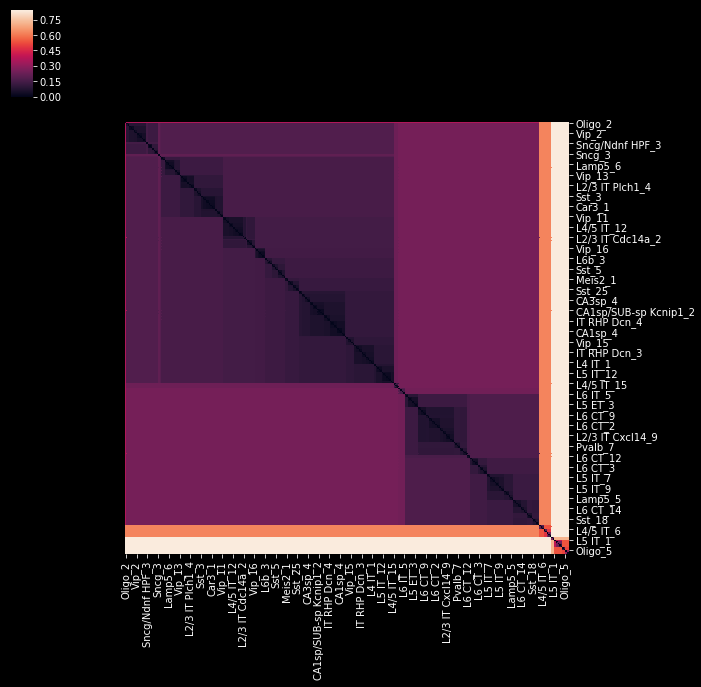

In [58]:
plt.style.use(['dark_background'])
df = pd.DataFrame(weight_matrix,index=cell_types,columns=cell_types)
sns.clustermap(df)#,cmap='bwr',center=0)
plt.show()

1110008P14Rik


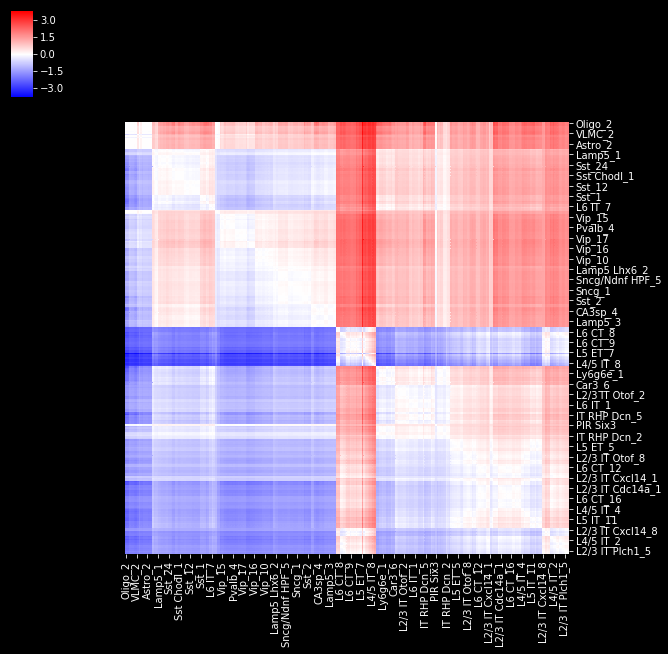

In [42]:
plt.style.use(['dark_background'])
i=0
print(filtered_genes[i])
df = pd.DataFrame(unweighted_seperability_matrix[:,:,i],index=cell_types,columns=cell_types)
sns.clustermap(df,cmap='bwr',center=0)
plt.show()

1500009L16Rik


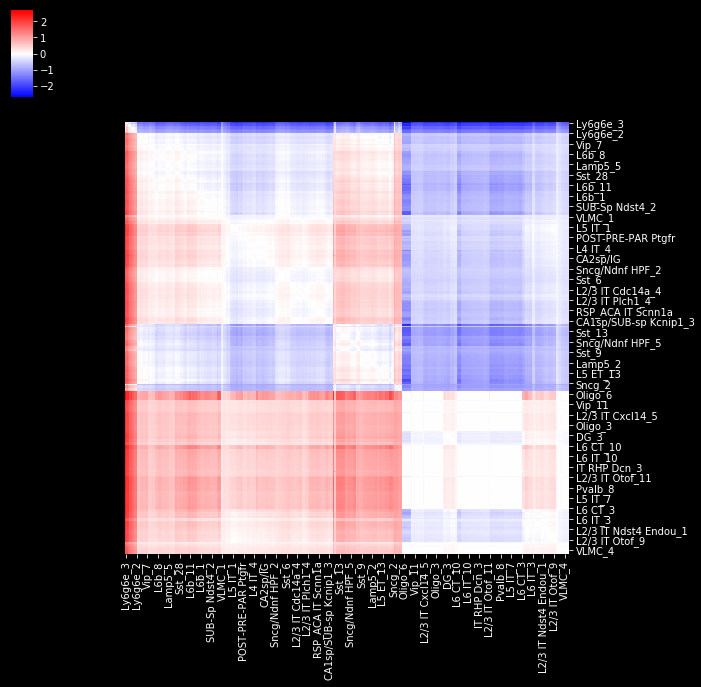

In [43]:
plt.style.use(['dark_background'])
i=1
print(filtered_genes[i])
df = pd.DataFrame(unweighted_seperability_matrix[:,:,i],index=cell_types,columns=cell_types)
sns.clustermap(df,cmap='bwr',center=0)
plt.show()

1700001L19Rik


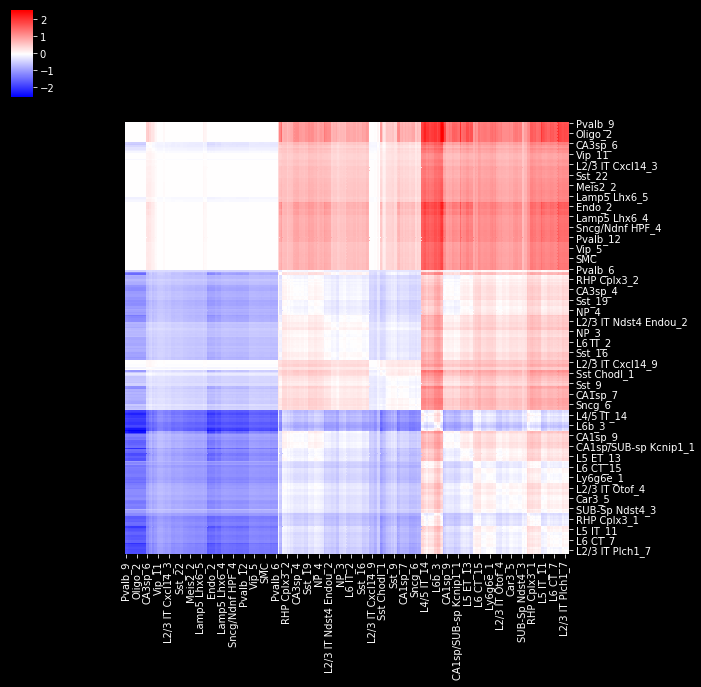

In [44]:
plt.style.use(['dark_background'])
i=3
print(filtered_genes[i])
df = pd.DataFrame(unweighted_seperability_matrix[:,:,i],index=cell_types,columns=cell_types)
sns.clustermap(df,cmap='bwr',center=0)
plt.show()

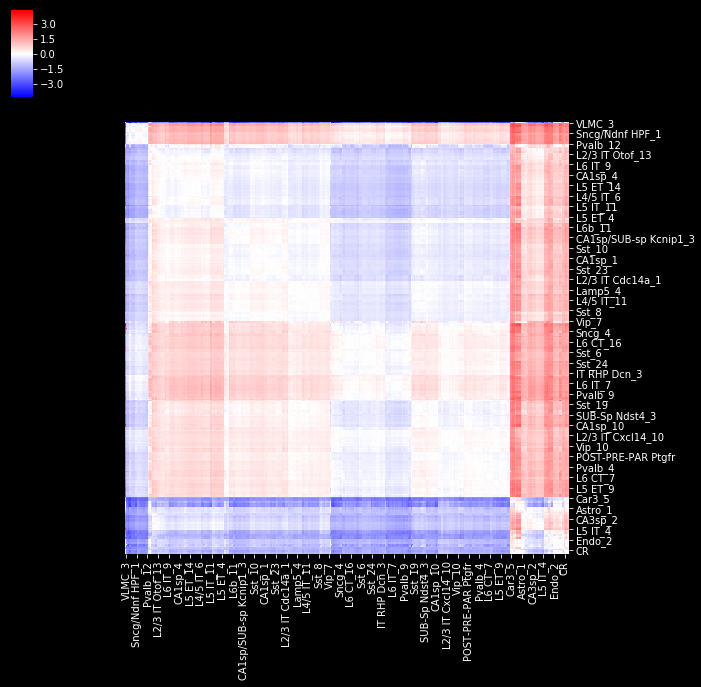

In [49]:
plt.style.use(['dark_background'])
df1 = pd.DataFrame(unweighted_seperability_matrix[:,:,1],index=cell_types,columns=cell_types)
df2 = pd.DataFrame(unweighted_seperability_matrix[:,:,2],index=cell_types,columns=cell_types)
df3 = df1-df2
sns.clustermap(df3,cmap='bwr',center=0)
plt.show()

1110008P14Rik


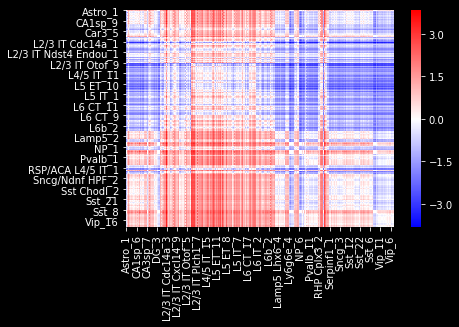

In [103]:
plt.style.use(['dark_background'])
i=0
print(filtered_genes[i])
df = pd.DataFrame(unweighted_seperability_matrix[:,:,i],index=cell_types,columns=cell_types)
sns.heatmap(df,cmap='bwr',center=0)
plt.show()

1500009L16Rik


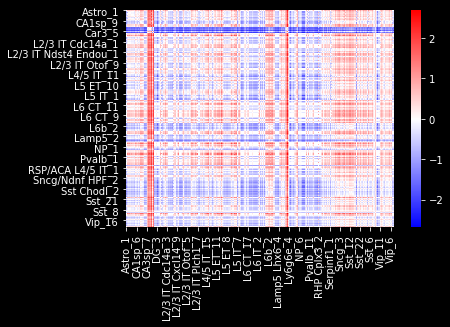

In [104]:
plt.style.use(['dark_background'])
i=1
print(filtered_genes[i])
df = pd.DataFrame(unweighted_seperability_matrix[:,:,i],index=cell_types,columns=cell_types)
sns.heatmap(df,cmap='bwr',center=0)
plt.show()

1500011B03Rik


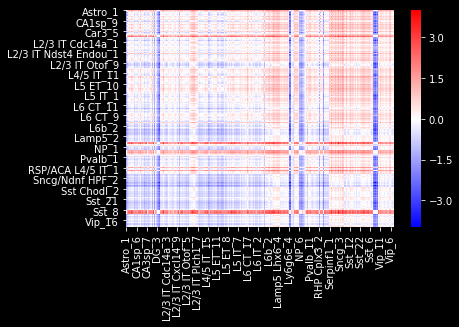

In [105]:
plt.style.use(['dark_background'])
i=2
print(filtered_genes[i])
df = pd.DataFrame(unweighted_seperability_matrix[:,:,i],index=cell_types,columns=cell_types)
sns.heatmap(df,cmap='bwr',center=0)
plt.show()

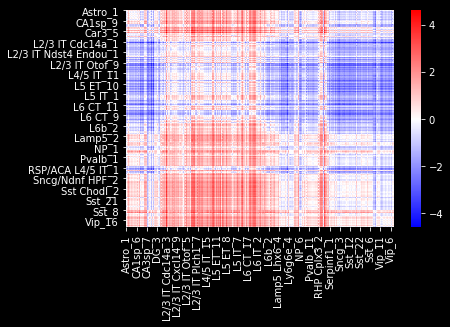

In [107]:
plt.style.use(['dark_background'])
df1 = pd.DataFrame(unweighted_seperability_matrix[:,:,0],index=cell_types,columns=cell_types)
df2 = pd.DataFrame(unweighted_seperability_matrix[:,:,1],index=cell_types,columns=cell_types)
sns.heatmap(df1-df2,cmap='bwr',center=0)
plt.show()

In [108]:
cell_type_medians.shape

(290, 1220)

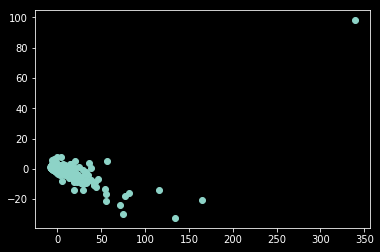

In [112]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(cell_type_medians.T)
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(x)
plt.scatter(principalComponents[:,0],principalComponents[:,1])
plt.show()

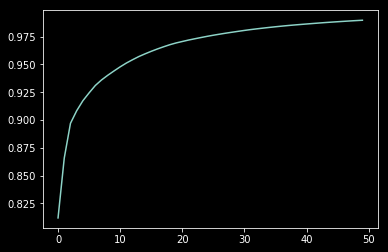

In [117]:
plt.plot(range(0,50),np.cumsum(pca.explained_variance_ratio_))

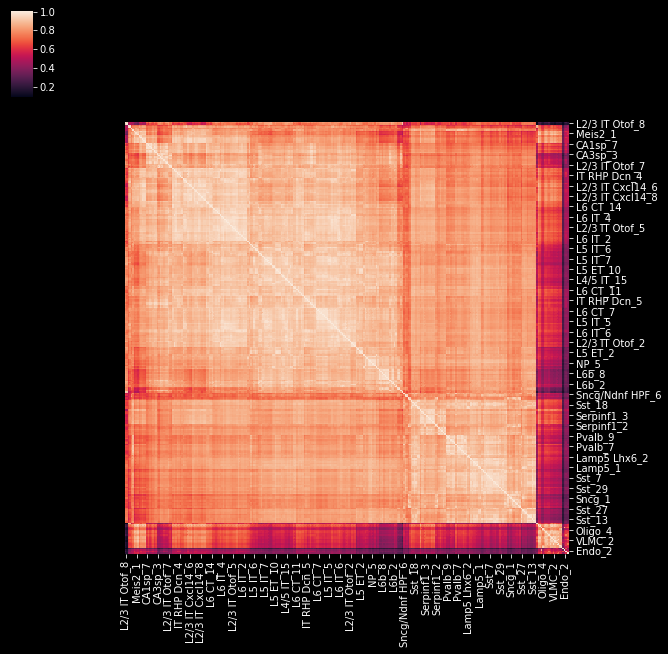

In [122]:
sns.clustermap(pd.DataFrame(pca.get_covariance(),index=cell_types,columns=cell_types))
plt.show()

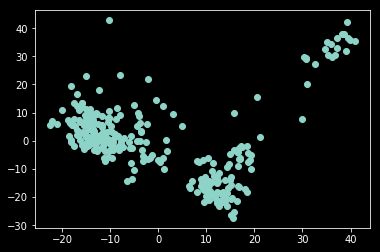

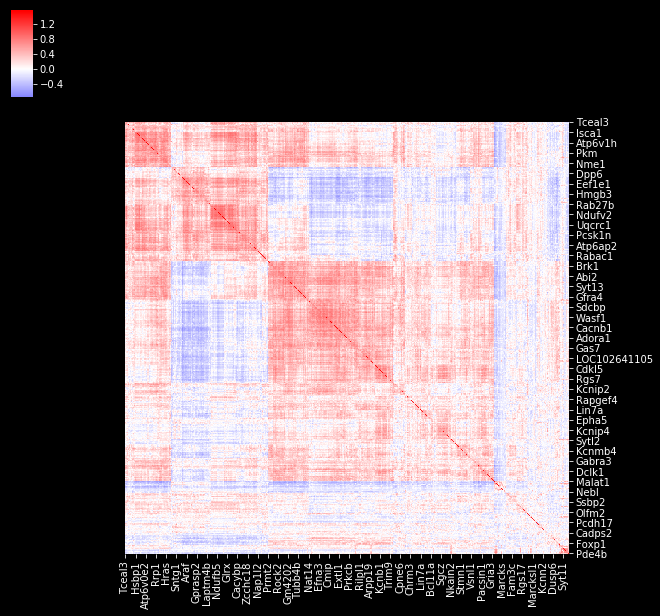

In [125]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(cell_type_medians)
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(x)
plt.scatter(principalComponents[:,0],principalComponents[:,1])
plt.show()
sns.clustermap(pd.DataFrame(pca.get_covariance(),index=filtered_genes,columns=filtered_genes),cmap='bwr',center=0)
plt.show()

In [126]:
"""
Loading Data from backup
"""
raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/filtered_raw_counts.npz'))
cells =  np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_cells.csv'),index_col=0)['0'])
genes = np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_genes.csv'),index_col=0)['0'])
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
raw_counts = raw_counts_sparse.A

In [127]:
"""
Normalize by cell size
"""
normalized_raw_counts = np.divide(raw_counts,np.sum(raw_counts,axis=0))*10**6

In [128]:
"""
Calculate median and variance for each gene for each cell type
"""
indexes = list(range(len(cells)))
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(genes)
normalized_cell_type_medians= np.zeros((n_cell_types,ngenes))
normalized_cell_type_variance = np.zeros((n_cell_types,ngenes))
for i,cell_type in enumerate(cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        cel_type_counts = normalized_raw_counts[:,loc]
        normalized_cell_type_medians[i,:] = np.median(cel_type_counts,axis=1)
        normalized_cell_type_variance[i,:] = np.std(cel_type_counts,axis=1)

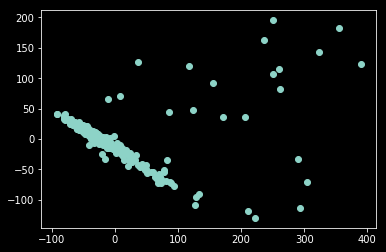

In [ ]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(normalized_cell_type_variance)
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(x)
plt.scatter(principalComponents[:,0],principalComponents[:,1])
plt.show()
sns.clustermap(pd.DataFrame(pca.get_covariance(),index=genes,columns=genes),cmap='bwr',center=0)
plt.show()

In [ ]:
covariance = pd.DataFrame(pca.get_covariance(),index=genes,columns=genes)
sns.clustermap(covariance,cmap='bwr',center=0)
plt.show()

In [14]:
import matplotlib as mpl
plt.style.use(['dark_background'])
def plot_dendrogram(linkage,accuracy_matrix):
    Z = linkage.copy()
    Z[:,2] = np.log10(Z[:,2]+1)
    cmap = matplotlib.cm.plasma(accuracy_matrix)
    temp = [matplotlib.colors.rgb2hex(rgb[:3]) for rgb in cmap]
    link_cols = {}
    for i,c in enumerate(temp):
        link_cols[i] = c
    ax = plt.figure(figsize=[5,10])
    D = shc.dendrogram(Z=Z,
                       link_color_func=lambda x: link_cols[x],
                       orientation='left',no_labels=True)
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(norm=norm,cmap='plasma')
    sm.set_array([])
    plt.colorbar(sm)
    plt.show()

In [18]:
species = pickle.load(open('/bigstore/GeneralStorage/Zach/CSI/Allen_CSI/elite_survivor_13.pkl','rb'))

In [19]:
species

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

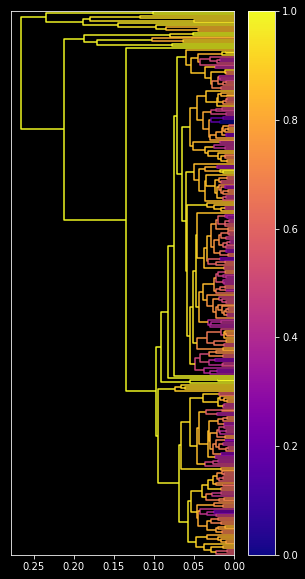

In [20]:
compressed = CSC.generate_compressed(species)
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)

In [21]:
metric = CSC.calculate_metric(compressed)
metric

2.090578739948005

1.8237571290346966


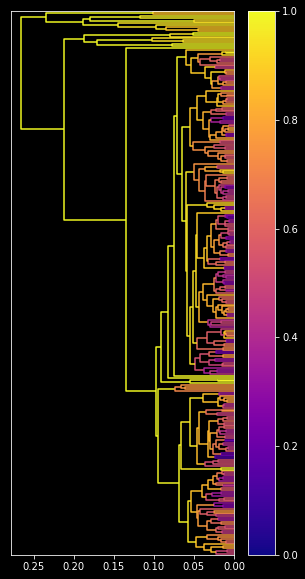

In [17]:
species = CSC.generate_random()
compressed = CSC.generate_compressed(species)
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
metric = CSC.calculate_metric(compressed)
print(metric)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)

In [ ]:
species = CSC.survivors[0]
compressed = CSC.generate_compressed(species)
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)

In [13]:
a = [print(i) for i in metadata.columns]

cluster_color
cluster_order
cluster_label
class_color
class_order
class_label
subclass_color
subclass_order
subclass_label
full_genotype_color
full_genotype_order
full_genotype_label
donor_sex_color
donor_sex_order
donor_sex_label
region_color
region_order
region_label
cortical_layer_color
cortical_layer_order
cortical_layer_label
cell_type_accession_color
cell_type_accession_order
cell_type_accession_label
cell_type_alias_color
cell_type_alias_order
cell_type_alias_label
cell_type_alt_alias_color
cell_type_alt_alias_order
cell_type_alt_alias_label
cell_type_designation_color
cell_type_designation_order
cell_type_designation_label
external_donor_name_color
external_donor_name_order
external_donor_name_label
facs_population_plan_color
facs_population_plan_order
facs_population_plan_label
injection_materials_color
injection_materials_order
injection_materials_label
injection_method_color
injection_method_order
injection_method_label
injection_roi_color
injection_roi_order
injection_roi_l